# Data Merge
This notebook describes steps to pull the stats from the txt files and combine them to create the final data structure.

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import re
from collections import OrderedDict
from datetime import datetime

### Location Path
Define the location of files here.

In [78]:
DATA_PATH = '/Users/stereopickles/CU_Google_Drive/COLUMBIA/DSI-Schizo/Data2020/DATA040320'
HC_PATH = f"{DATA_PATH}/HC/COBRE_prep/HC_Stats"
SZ_PATH = f"{DATA_PATH}/SZ/COBRE_prep/SZ_Stats"
HC_FAT_DTI_PATH = f'{HC_PATH}/FAT'
SZ_FAT_DTI_PATH = f'{SZ_PATH}/FAT'
HC_UF_DTI_PATH = f'{HC_PATH}/UF'
SZ_UF_DTI_PATH = f'{SZ_PATH}/UF'

In [79]:
TRACTS = ['FAT', 'UF']
CONDS = ['SZ', 'HC']

In [80]:
# full subject lists

with open(f'{DATA_PATH}/subject_list.txt', 'r') as f: 
    subjects = f.read()
    
subjects = [re.sub('A', '', x) for x in subjects.split('\n')]

### Extract stats 
The resulting table should look like 
| subnum | admin | condition | tract | datetime | side | track_count | voxel_count | mean_length | mean_FA_trk | mean_Ang | mean_FA | mean_AD | mean_MD | mean_RD | 

In [81]:
def find_num(str_):
    return int(re.findall('(?<=: )([.0-9]*)', str_)[0])

def find_mean_se(str_):
    mean = float([x if x != 'nan' else 0 for x in re.findall('(?<=: )([na.0-9]*)', str_)][0])
    se = float(re.findall('(?<=- )([.0-9]*)', str_)[0])
    return mean, se

def find_type(str_):
    return re.findall('(?<=DTI_)([A-Z]*)', str_)[0]

def find_year(str_):
    return int(re.findall('(?<=ses-)([0-9]*)', str_)[0][:4])

In [135]:
def extract_stats(list_, group = {'FAT', 'UF'}):
    ''' From a list of lines extract information '''
    result = {}
    for i in range(0, len(list_), 12): # iterate every 12 lines
        
        # find tract groups
        grp = re.findall('(?<=: )(.*)(?=\\n)', list_[i])[0]
        trk_group = re.findall('(FAT|UF)', grp)[0]
        
        # find which hemisphere
        side = grp[-1]
        
        if trk_group in group:
            # get stats
            trk_cnt = find_num(list_[i+1]) # track count
            vxl_cnt = find_num(list_[i+2]) # voxel count
            mean_length, se_length = find_mean_se(list_[i+4]) # mean length + se length
            mean_fatrk, se_fatrk = find_mean_se(list_[i+5]) # mean fa track + se fa track
            mean_angtrk, se_angtrk = find_mean_se(list_[i+6]) # mean ang track + se 
            yr_scan = find_year(list_[i+7]) # year scanned
            stats = {}
            
            # AD, MD, RD, FA values
            for j in range(7, 11): 
                stats[find_type(list_[i+j])] = find_mean_se(list_[i+j])
            
            # if all 4 are not there something's wrong
            if len(stats) != 4: 
                print('not enough stats')
            
            # compile
            info = {'track_count': trk_cnt, 
                    'voxel_count': vxl_cnt, 
                    'mean_length': mean_length, 
                    'se_length': se_length, 
                    'mean_fatrk': mean_fatrk, 
                    'se_fatrk': se_fatrk, 
                    'mean_angtrk': mean_angtrk, 
                    'se_angtrk': se_angtrk, 
                    'mean_AD': stats['AD'][0], 
                    'se_AD': stats['AD'][1], 
                    'mean_FA': stats['FA'][0], 
                    'se_FA': stats['FA'][1],
                    'mean_MD': stats['MD'][0], 
                    'se_MD': stats['MD'][1],
                    'mean_RD': stats['RD'][0], 
                    'se_RD': stats['RD'][1],
                    'yr_scan': yr_scan
                   }
            
            # log
            if trk_group in result:
                result[trk_group][side] = info
            else:
                result[trk_group] = {side: info}
        else:
            continue
    return result

In [136]:
df = pd.DataFrame(
    columns = ['subnum', 'admin', 'condition', 'tract', 'datetime_extracted', 'side', 'note',
               'track_count', 'voxel_count', 'mean_length', 'se_length',  'mean_fatrk',
               'se_fatrk', 'mean_angtrk', 'se_angtrk', 'mean_AD', 'se_AD', 'mean_FA',
               'se_FA', 'mean_MD', 'se_MD', 'mean_RD', 'se_RD', 'yr_scan'])

In [137]:
def process_file(fp, fn, cnd, trs = {'FAT', 'UF'}, admin = None): 
    ''' 
    INPUT
    =======
    fp: file path
    fn: file name 
    cnd: condition (SZ or HC)
    trs: a set of tracts to include 
    admin: the name of admin (default: None)
    
    OUTPUT
    =======
    a nested list of stats in this order: 
    [[subnum, admin, cnd, tr, dt, side, note, {stats}], ...]

    '''
    
    # check if the file exists
    if os.path.exists(fp): 
        pass
    else:
        fp = fp[:-4]
        if os.path.exists(fp): 
            pass
        else:
            print(f'The file does not exist: {fp}')
        

    # get modified time
    dt = os.path.getmtime(fp)
    dt = datetime.fromtimestamp(dt).strftime('%Y-%m-%d %H:%M:%S')

    # get subject number and notes from the file name
    subnum, note = re.findall('(?<=sub-A)([0-9]*)(.*)(?=.txt)', fn)[0]
    print(f'{subnum}', end = '')

    # open file and extract stats
    with open(fp, 'r') as f: 
        line = f.readlines()
        line = [re.sub('(?:(?<=FAT)|(?<=UF))_', '', x) for x in line]
        info = extract_stats(line, group = trs)
    
    result = []
    # if info is not empty, create a list
    if info:
        print('(o)', end = ' ')
        for tr in trs: 
            for side in info[tr].keys():
                # one entry per side X tracts
                vals = []
                for k in info[tr][side].keys():
                    vals.append(info[tr][side][k])
                full_list = [subnum, admin, cnd, tr, dt, side, note]
                full_list.extend(vals)
                result.append(full_list)

    else:
        print('(x)', end = ' ')

    return result


In [138]:
#i = 0
for tr in TRACTS:
    for cnd in CONDS: 
        path = f'{DATA_PATH}/{cnd}/COBRE_prep/{cnd}_Stats/{tr}'
        print(f'{cnd}_{tr}', end = '\n=======\n')
        
        # get the names of directories within path
        try:
            sub_dirs = next(os.walk(path))[1]
        except StopIteration: 
            print("Directory doesn't exist")
            break
            
        # each sub-dir should be the name of administrator
        for admin in sub_dirs: 
            print(f'{admin}', end = '\n-------\n')
            
            # get the list of files (must start with 'sub')
            files = [x for x in os.listdir(os.path.join(path, admin)) if x.startswith('sub')]
            
            # add extension if it doesn't have one
            files = [f if f.endswith('.txt') else f + '.txt' for f in files]
            
            for fn in files:
                
                fp = os.path.join(path, admin, fn)
                result = process_file(fp, fn, cnd, trs = {tr}, admin = admin) 
                
                for x in result: 
                    df.loc[len(df)+1] = x
                
            print('\n')

SZ_FAT
HW
-------
00024684(o) 00038441(o) 00035836(o) 00020787(o) 00014636(o) 00027969(o) 00019349(o) 00037854(o) 00024568(o) 00024959(o) 00023158(o) 00038624(o) 00037649(o) 00038172(o) 00023750(o) 00027537(o) 00028189(o) 00024228(o) 00028404(o) 00027119(o) 00035859(o) 00022500(o) 00024953(o) 00024198(o) 00035485(o) 00023243(o) 00037034(o) 00020602(o) 00027391(o) 00037619(o) 00027755(o) 00037224(o) 00023246(o) 

IR
-------


SS
-------
00018598(o) 00017147(o) 00000909(o) 00001243(o) 00020414(o) 00016720(o) 00018403(o) 00014804(o) 00016197(o) 00015518(o) 00001251(o) 00014175(o) 00018317(o) 00001452(o) 00000368(o) 00009280(o) 00015648(o) 00020416(o) 00016723(o) 00014607(o) 00000456(o) 00000838(o) 00014830(o) 00014719(o) 00018129(o) 00000541(o) 00018979(o) 00019293(o) 

HC_FAT
HW
-------
00020805(o) 00025969(o) 00021058(o) 00013363(o) 00003150(o) 00021072(o) 00026907(o) 00018553(o) 00037007(o) 00014225(o) 00028052(o) 00024535(o) 00010684(o) 00022490(o) 00011265(o) 00004087(o) 00022727(o) 

In [139]:
df.sample(5)

,subnum,admin,condition,tract,datetime_extracted,side,note,track_count,voxel_count,mean_length,...,se_angtrk,mean_AD,se_AD,mean_FA,se_FA,mean_MD,se_MD,mean_RD,se_RD,yr_scan
20,00024959,HW,SZ,FAT,2020-11-24 02:27:58,R,,160,677,75.1438,...,4.5760,1.1001,0.1945,0.4448,0.1285,0.7333,0.1395,0.5499,0.1539,2009
187,00021085,HW,HC,FAT,2020-12-22 14:59:10,L,,170,539,68.8765,...,4.5170,1.1779,0.1760,0.4791,0.1446,0.7508,0.0809,0.5373,0.1176,2010
252,00027537,HW,SZ,UF,2020-11-24 02:42:02,R,,463,1474,99.4363,...,4.4150,1.2241,0.1606,0.4091,0.1291,0.8308,0.1072,0.6341,0.1365,2011
126,00025969,HW,HC,FAT,2021-01-03 14:11:00,R,,220,806,78.0909,...,3.8977,1.1904,0.1747,0.4533,0.1404,0.7836,0.1055,0.5802,0.1392,2009
96,00000368,SS,SZ,FAT,2020-12-23 14:37:29,R,,415,1123,70.4675,...,3.7681,1.1968,0.2068,0.4455,0.1227,0.7859,0.1304,0.5804,0.1360,2011


## Get Missing Entries from the ARCHIVE
Since all entries have been reviewed, if it's missing above, it means the old file didn't need to be updated after the review.  
So we'll pull the missing subject information from the archived stat files.


In [211]:
missing_FAT = [x for x in subjects if x != '' and x not in df[df.tract == 'FAT'].subnum.unique()]
missing_UF = [x for x in subjects if x != '' and x not in df[df.tract == 'UF'].subnum.unique()]

In [212]:
ARCHIVE_HC = f'{DATA_PATH}/HC/COBRE_prep/HC_Stats/ARCHIVE_06_2020'
ARCHIVE_SZ = f'{DATA_PATH}/SZ/COBRE_prep/SZ_Stats/ARCHIVE_06_2020'

In [213]:
HC_lists = [x for x in os.listdir(ARCHIVE_HC) if x.startswith('sub')]
SZ_lists = [x for x in os.listdir(ARCHIVE_SZ) if x.startswith('sub')]

In [214]:
HC_subjects = {re.findall('(?<=A)[0-9]*', x)[0]: f"{ARCHIVE_HC}/{x}" for x in HC_lists}
SZ_subjects = {re.findall('(?<=A)[0-9]*', x)[0]: f"{ARCHIVE_SZ}/{x}" for x in SZ_lists}

In [221]:
for tr in ['FAT', 'UF']: 
    
    missing = tr == 'FAT' and missing_FAT or missing_UF
        
    for sub in missing: 
        for cnd in ['HC', 'SZ']:
        
            cond_dict = cnd == 'HC' and HC_subjects or SZ_subjects
            
            if sub in cond_dict: 
                fp = cond_dict[sub]
                fn = fp.split('/')[-1]
                result = process_file(fp, fn, cnd, trs = {tr}) 

                for x in result: 
                    df.loc[len(df)+1] = x                

00037238(o) 00026945(o) 00036916(o) 00024955(o) 00024546(o) 00023848(o) 00024301(o) 00023131(o) 00018598(o) 00019293(o) 00020414(o) 00018317(o) 00015648(o) 00016197(o) 00014804(o) 00018403(o) 00014719(o) 00016720(o) 00016723(o) 00000838(o) 00000541(o) 00001452(o) 00001243(o) 00000456(o) 00018979(o) 00001251(o) 00020416(o) 00015518(o) 00018129(o) 00000909(o) 00014175(o) 00014607(o) 00017147(o) 00014830(o) 00009280(o) 00000368(o) 

## Check for Duplicates
let's check if there are only one entry per subnum x side. If there are more than one, let's confirm that numbers are the same. If numbers are the same, only leave one.

In [140]:
entry_counts = df.groupby(['subnum', 'tract', 'side']).subnum.count().unstack()

In [142]:
dupes = list(entry_counts[(entry_counts.L > 1) | (entry_counts.R > 1) ].reset_index().subnum.values)

In [226]:
tmp = df[df.subnum.isin(dupes)].sort_values(['subnum', 'side'])

In [322]:
tmp.iloc[:, 0:5]

,subnum,admin,condition,tract,datetime_extracted
195,00007409,HW,HC,FAT,2020-11-23 21:40:52
199,00007409,HW,HC,FAT,2020-11-23 21:34:14
361,00007409,HW,HC,UF,2020-11-23 21:40:52
367,00007409,HW,HC,UF,2020-11-23 21:34:14
196,00007409,HW,HC,FAT,2020-11-23 21:40:52
200,00007409,HW,HC,FAT,2020-11-23 21:34:14
362,00007409,HW,HC,UF,2020-11-23 21:40:52
368,00007409,HW,HC,UF,2020-11-23 21:34:14


In [250]:
## Generate a report
with open('duplicates.txt', 'w+') as f: 
    f.write(f"Below subject has duplicate records.\n\n{tmp.iloc[:, 0:5]}")

In [ ]:
# TODO: fix the above

#### Total Counts

In [245]:
df.groupby(['condition', 'tract']).subnum.nunique()

condition  tract
HC         FAT      69
           UF       69
SZ         FAT      61
           UF       61
Name: subnum, dtype: int64

## Add Notes 
Add review notes from analysis log

In [502]:
alog = pd.read_csv('log/200114_analysis_log.csv')

In [503]:
alog = alog[['sub', 'Nov 2020 - FAT comments', 'Nov 2020 - UF comments']].copy()
alog.rename(columns = {'sub': 'subnum', 'Nov 2020 - FAT comments': 'FAT_note', 'Nov 2020 - UF comments': 'UF_note'}, inplace = True)
alog.dropna(subset = ['subnum'], inplace = True)

In [505]:
# drop A in subnum names
alog.subnum = [x[1:] for x in alog.subnum]

In [512]:
# separate out FAT / UF 
FAT_notes = alog[['subnum', 'FAT_note']].copy()
FAT_notes.loc[:, 'tract'] = 'FAT'
FAT_notes.rename(columns = {'FAT_note': 'note'}, inplace = True)
UF_notes = alog[['subnum', 'UF_note']].copy()
UF_notes.loc[:, 'tract'] = 'UF'
UF_notes.rename(columns = {'UF_note': 'note'}, inplace = True)

In [514]:
alog = pd.concat([FAT_notes, UF_notes])

In [517]:
df = df.rename(columns = {'note': 'fn_note'})

In [521]:
len()

,subnum,admin,condition,tract,datetime_extracted,side,fn_note,track_count,voxel_count,mean_length,...,mean_FA,se_FA,mean_MD,se_MD,mean_RD,se_RD,yr_scan,lateral_missing,missing,any_tract_missing
1,00024684,HW,SZ,FAT,2020-11-24 02:20:18,L,,515,1259,70.6583,...,0.4766,0.1420,0.7591,0.0903,0.5423,0.1271,2010,False,False,False
2,00024684,HW,SZ,FAT,2020-11-24 02:20:18,R,,69,516,73.4203,...,0.4158,0.1430,0.7658,0.0925,0.5853,0.1278,2010,False,False,False
3,00038441,HW,SZ,FAT,2020-12-22 15:45:40,L,,29,242,74.0345,...,0.3919,0.1476,0.7632,0.0925,0.5897,0.1236,2013,False,False,False
4,00038441,HW,SZ,FAT,2020-12-22 15:45:40,R,,269,860,69.9628,...,0.4062,0.1360,0.7613,0.0825,0.5829,0.1068,2013,False,False,False
5,00035836,HW,SZ,FAT,2020-12-22 15:25:51,L,,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2013,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,00014830,None,SZ,UF,2020-06-06 00:46:16,L,,24,231,96.9583,...,0.4504,0.1427,0.7868,0.1262,0.5833,0.1485,2009,False,False,True
521,00009280,None,SZ,UF,2020-06-16 00:11:48,R,,87,581,89.3793,...,0.4101,0.1125,0.7998,0.0799,0.6081,0.1020,2011,False,False,False
522,00009280,None,SZ,UF,2020-06-16 00:11:48,L,,147,916,86.3741,...,0.4360,0.1478,0.7696,0.0963,0.5758,0.1371,2011,False,False,False
523,00000368,None,SZ,UF,2020-06-01 22:24:22,L,_ROI,35,337,78.6571,...,0.3481,0.1211,0.7859,0.1216,0.6368,0.1415,2011,False,False,False


In [523]:
df = pd.merge(df, alog, on = ['subnum', 'tract'], how = 'left')

## Check for Zero values
Remove zero value rows  
Add a column that indicates whether the both side exists or not

In [524]:
df['missing'] = np.where(df.track_count == 0, True, False)

In [525]:
for subnum, tr, side in df[df.missing][['subnum', 'tract', 'side']].values: 
    opposite_side = side == 'L' and 'R' or 'L'
    df.loc[df[(df.subnum == subnum) & (df.side == opposite_side) & (df.tract == tr)].index[0], 'lateral_missing'] = True

In [526]:
# add a column if the other tract group is missing on either side
missing = df[df.missing]['subnum'].values
df['any_tract_missing'] = np.where(df.subnum.isin(missing), True, False)

#### Total Counts of complete brains

In [527]:
df[~df.any_tract_missing].groupby(['condition', 'tract']).subnum.nunique()

condition  tract
HC         FAT      49
           UF       49
SZ         FAT      44
           UF       44
Name: subnum, dtype: int64

#### Total Counts of Complete Tracts

In [528]:
df[~(df.missing | df.lateral_missing)].groupby(['condition', 'tract']).subnum.nunique()

condition  tract
HC         FAT      50
           UF       68
SZ         FAT      47
           UF       58
Name: subnum, dtype: int64

## Data Type
Confirming data types

In [529]:
#df.info()

datetime_extracted should be a datetime object.   
track_count and voxel_count should be integers.

In [530]:
df.datetime_extracted = pd.to_datetime(df.datetime_extracted)

In [531]:
df.track_count = df.track_count.astype('int')
df.voxel_count = df.voxel_count.astype('int')

In [532]:
clean_df = df[~(df.missing | df.lateral_missing)]

In [533]:
clean_df.describe()

,track_count,voxel_count,mean_length,se_length,mean_fatrk,se_fatrk,mean_angtrk,se_angtrk,mean_AD,se_AD,mean_FA,se_FA,mean_MD,se_MD,mean_RD,se_RD
count,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000
mean,207.566964,866.560268,84.343808,9.359852,0.393875,0.121922,6.382530,4.566453,1.185490,0.181793,0.425323,0.131338,0.795796,0.112465,0.600950,0.136860
std,146.537593,432.414304,12.883946,5.590328,0.029146,0.014675,0.665261,0.494540,0.055846,0.040894,0.030227,0.013425,0.039967,0.041208,0.039791,0.035545
min,3.000000,91.000000,52.000000,1.329200,0.313700,0.073800,4.467400,3.158400,1.034000,0.094200,0.338500,0.080300,0.682700,0.058200,0.499400,0.083100
25%,92.000000,557.000000,73.356725,5.167650,0.373850,0.112375,5.945675,4.239450,1.144750,0.160800,0.405875,0.122225,0.766975,0.089275,0.569625,0.115975
50%,188.500000,833.500000,83.026400,8.292400,0.394350,0.121000,6.348150,4.532900,1.187450,0.176150,0.424850,0.130950,0.794200,0.105950,0.598150,0.131650
75%,289.500000,1150.250000,94.958350,12.422050,0.414525,0.131300,6.746125,4.840925,1.225300,0.192925,0.447250,0.141025,0.820600,0.124825,0.626575,0.148425
max,879.000000,2665.000000,121.574800,36.032900,0.477600,0.180400,9.714200,6.750900,1.334300,0.642600,0.505000,0.184000,0.913200,0.533500,0.734200,0.496100


Even without 0 values, there are ones that has less than 10 tracks. Are these ok?

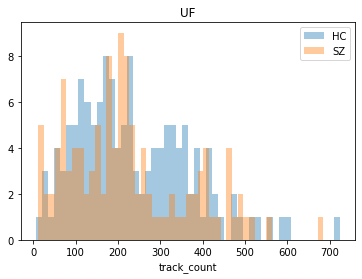

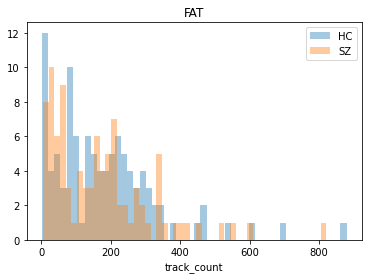

In [534]:
sns.distplot(clean_df[(clean_df.tract == 'UF') & (clean_df.condition == 'HC')].track_count, label = 'HC', kde = False, bins = 50)
sns.distplot(clean_df[(clean_df.tract == 'UF') & (clean_df.condition == 'SZ')].track_count, label = 'SZ', kde = False, bins = 50)
plt.legend()
plt.title('UF')
plt.show()

sns.distplot(clean_df[(clean_df.tract == 'FAT') & (clean_df.condition == 'HC')].track_count, label = 'HC', kde = False, bins = 50)
sns.distplot(clean_df[(clean_df.tract == 'FAT') & (clean_df.condition == 'SZ')].track_count, label = 'SZ', kde = False, bins = 50)
plt.legend()
plt.title('FAT')
plt.show()

## Check for Outliers
Instead of checking outliers based on a specific value, I'm going to cluster values based on voxel and track counts, and see if there are ones that stand out. (per different tracts)

In [535]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

In [536]:
from sklearn.cluster import AgglomerativeClustering

In [563]:
df.groupby(['condition', 'tract', 'side']).subnum.nunique()

condition  tract  side
HC         FAT    L       69
                  R       69
           UF     L       69
                  R       69
SZ         FAT    L       61
                  R       61
           UF     F        1
                  L       61
                  R       60
Name: subnum, dtype: int64

In [566]:
clean_df.groupby(['condition', 'tract', 'side']).subnum.nunique()

condition  tract  side
HC         FAT    L       50
                  R       50
           UF     L       68
                  R       68
SZ         FAT    L       47
                  R       47
           UF     F        1
                  L       58
                  R       57
Name: subnum, dtype: int64

In [567]:
clean_df[clean_df.track_count <= 50].groupby(['condition', 'tract', 'side']).subnum.nunique()

condition  tract  side
HC         FAT    L        8
                  R        9
           UF     L        3
                  R        2
SZ         FAT    L       13
                  R       10
           UF     L        7
                  R        2
Name: subnum, dtype: int64

In [565]:
df[df.track_count >= 300].groupby(['condition', 'tract', 'side']).subnum.nunique()

condition  tract  side
HC         FAT    L        7
                  R        9
           UF     L       15
                  R       28
SZ         FAT    L        6
                  R        9
           UF     L        8
                  R       21
Name: subnum, dtype: int64

### FAT only

In [537]:
cols = ['track_count', 'voxel_count']

#### FAT-Left

In [538]:
def get_X(df):
    X = df[cols].values
    scaler = StandardScaler()
    return scaler.fit_transform(X)
    
def plot_dendrogram(X):
    lnk_arr = linkage(X, method = 'ward')
    plt.figure(figsize=(25, 8))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Index')
    plt.ylabel('Distance')
    dendrogram(
        lnk_arr,
        leaf_rotation=90.,
        leaf_font_size=8.) 
    plt.show()

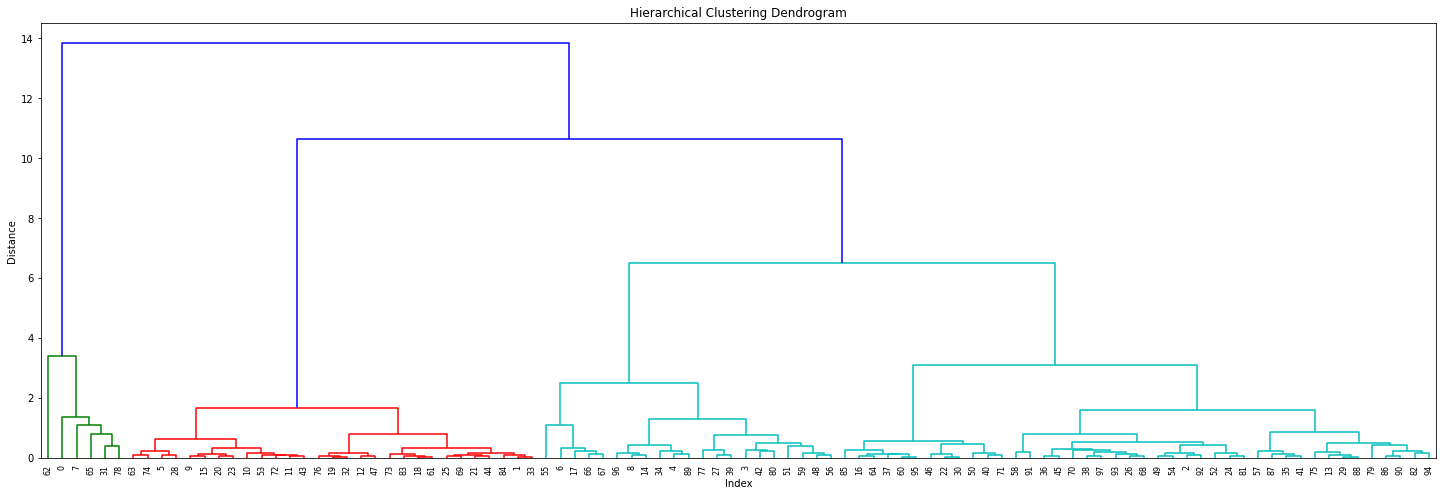

In [539]:
FATdf_L = clean_df[(clean_df.tract == 'FAT') & (clean_df.side == 'L')].reset_index()
x_std = get_X(FATdf_L)
plot_dendrogram(x_std)

In [540]:
def plot_clusters(x, n = 3): 
    clusters = AgglomerativeClustering(n_clusters = n)
    pred = clusters.fit_predict(x)
    plt.scatter(x[:, 0], x[:, 1], c = pred, s = 10)
    plt.show()
    return pred

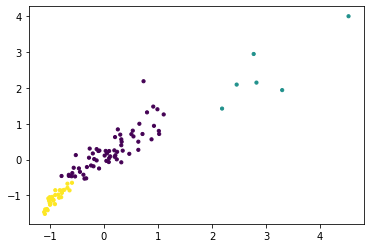

In [541]:
pred = plot_clusters(x_std)

In [542]:
from collections import Counter
Counter(pred)

Counter({1: 6, 2: 29, 0: 63})

In [543]:
zero_list = [k for k, v in dict(zip(range(len(pred)), pred)).items() if v == 0]
one_list = [k for k, v in dict(zip(range(len(pred)), pred)).items() if v == 1]
two_list = [k for k, v in dict(zip(range(len(pred)), pred)).items() if v == 2]

In [544]:
FATdf_L.iloc[one_list] # excessive track 

,index,subnum,admin,condition,tract,datetime_extracted,side,fn_note,track_count,voxel_count,...,se_FA,mean_MD,se_MD,mean_RD,se_RD,yr_scan,lateral_missing,missing,any_tract_missing,note
0,0,00024684,HW,SZ,FAT,2020-11-24 02:20:18,L,,515,1259,...,0.1420,0.7591,0.0903,0.5423,0.1271,2010,False,False,False,good
7,20,00023158,HW,SZ,FAT,2020-11-24 01:16:06,L,,606,1862,...,0.1299,0.8019,0.0686,0.6094,0.1121,2009,False,False,False,good
31,83,00016197,SS,SZ,FAT,2020-12-23 15:47:26,L,,557,1524,...,0.1560,0.7803,0.1066,0.5453,0.1449,2009,False,False,False,good
62,166,00014898,HW,HC,FAT,2020-11-23 22:28:23,L,,879,2279,...,0.1337,0.7950,0.1163,0.5890,0.1369,2009,False,False,False,good
65,174,00020895,HW,HC,FAT,2020-11-24 00:06:27,L,,688,1463,...,0.1457,0.7537,0.1181,0.5480,0.1460,2010,False,False,False,(L) preSMA removed
78,208,00024955,SS,HC,FAT,2020-12-21 00:37:44,L,,614,1546,...,0.1371,0.7687,0.1571,0.5694,0.1745,2009,False,False,False,"blue and light green looping in both FATs, sav..."


It seems like there are some that has excessive number of tracts. Most are marked to be good -- are we sure we are not going over the area?

### Right

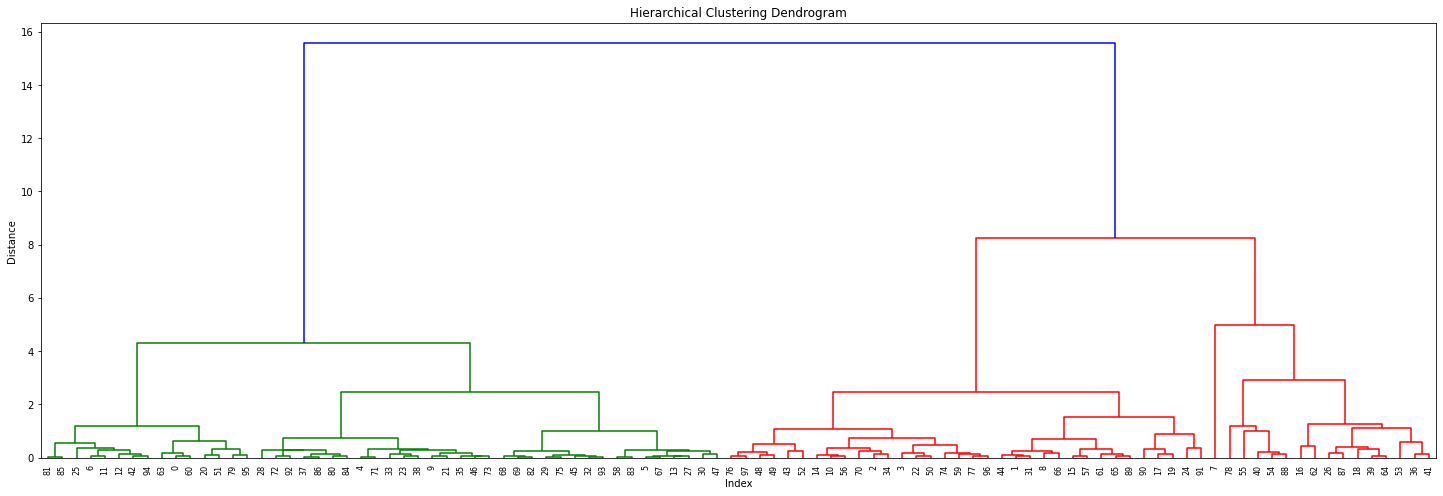

In [547]:
FATdf_R = clean_df[(clean_df.tract == 'FAT') & (clean_df.side == 'R')]
x_std = get_X(FATdf_R)
plot_dendrogram(x_std)

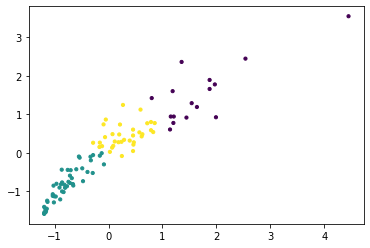

Counter({1: 48, 2: 34, 0: 16})

In [549]:
pred = plot_clusters(x_std)
Counter(pred)

There isn't as strong of an outlier groups